# Dataset analysis

## Common premable

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.abspath(''), '../'))

import peewee as pw
from toyDb.databases import ExperimentDb, ShaderDb
from toyDb.utils.Directory import getToyDbRootDir

import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
import torch

ExperimentDb.init_from_default_db()

## experiments.db & ShaderDb analysis

In [2]:
shaderDB = ShaderDb.ShaderDB(os.path.join(getToyDbRootDir(), "shaders"))
shaderDB.scan_local()
shaderDB.load_all()

all_shaders = set(shaderDB.offlineShaders.keys())
imageonly_shaders = shaderDB.filter_attribute(["is_imageonly"])

# all environments available in database
all_environments = ExperimentDb.Environment.select()

# shaders that have at least 1 non-error measurement
measurable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).where(
      ExperimentDb.ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE,
    ).distinct()
])

# shaders that have measurements in all working environments
all_measurable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).group_by(
      ExperimentDb.ImageOnlyShader.shader_id
    ).having(
      pw.fn.MAX(ExperimentDb.ImageOnlyExperiment.errors) == 0
    )
])

measurable_and_traceable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).where(
      ExperimentDb.ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE,
      ExperimentDb.ImageOnlyExperiment.trace.is_null(False)
    ).distinct()
])

all_measurable_and_traceable_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).group_by(
      ExperimentDb.ImageOnlyShader.shader_id
    ).having(
      pw.fn.MAX(ExperimentDb.ImageOnlyExperiment.errors) == 0,
      pw.fn.SUM(ExperimentDb.ImageOnlyExperiment.trace.is_null(True)) == 0
    )
])

all_measurable_and_traceable_canonical_shaders = set([shdr.shader_id for shdr in ExperimentDb.ImageOnlyShader.select(
      ExperimentDb.ImageOnlyShader.shader_id
    ).join(ExperimentDb.ImageOnlyExperiment).where(
      ExperimentDb.ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
      ExperimentDb.ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
      ExperimentDb.ImageOnlyExperiment.width == ExperimentDb.CANONICAL_WIDTH,
      ExperimentDb.ImageOnlyExperiment.height == ExperimentDb.CANONICAL_HEIGHT
    ).group_by(
      ExperimentDb.ImageOnlyShader.shader_id
    ).having(
      pw.fn.MAX(ExperimentDb.ImageOnlyExperiment.errors) == 0,
      pw.fn.SUM(ExperimentDb.ImageOnlyExperiment.trace.is_null(True)) == 0
    )
])

In [3]:
print(f"Number of shaders in Shadertoy Offline Database: {len(all_shaders)}")
print(f"Number of ImageOnly shaders: {len(imageonly_shaders)}")
print(f"Number of environments: {len(all_environments)}")

print(f"Number of measurable shaders: {len(measurable_shaders)}")
print(f"Number of all measurable shaders: {len(all_measurable_shaders)}")
print(f"Number of measurable and traceable shaders: {len(measurable_and_traceable_shaders)}")
print(f"Number of all measurable and traceable shaders: {len(all_measurable_and_traceable_shaders)}")
print(f"Number of all measurable and traceable canonical experimented shaders: {len(all_measurable_and_traceable_canonical_shaders)}")


Number of shaders in Shadertoy Offline Database: 0
Number of ImageOnly shaders: 0
Number of environments: 3
Number of measurable shaders: 14280
Number of all measurable shaders: 14280
Number of measurable and traceable shaders: 14261
Number of all measurable and traceable shaders: 11567
Number of all measurable and traceable canonical experimented shaders: 11568


In [4]:
measurable_shaders - measurable_and_traceable_shaders

{'4lscW2',
 '4syXRR',
 '7lXcW8',
 'DdS3Wh',
 'MllBR2',
 'Nd33Dr',
 'NtjcRV',
 'Wd3fDH',
 'WdKcWd',
 'XdSBDd',
 'XdyBWD',
 'Xl2cRR',
 'ddlXD4',
 'fdy3DW',
 'mdyGWG',
 'sdcGWB',
 'tsVcWt',
 'wdcSzn',
 'wltGWs'}

## Distribution analysis

There are several impact factors on training, including
- distribution of time
- distribution of trace count
- distribution of number of SPIR-V instructions
- distribution of number of tokens in tokenized shaders

The analysis is done for 3060 environment.

In [12]:
environment_selected = all_environments[2]
print(f"Environment selected: {environment_selected.node} - {environment_selected.cpu} - {environment_selected.gpu} - {environment_selected.gpu_driver}")

Environment selected: libreliu-GCL-Arch -  Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz - Intel(R) UHD Graphics 630 (CML GT2) - Intel open-source Mesa driver Mesa 23.2.1-arch1.2


In [13]:
# Select experiments where shaderIDs match the shaderID provided, and
# return the first if have multiple record
shader_to_experiment = {}
query = ExperimentDb.ImageOnlyExperiment.select(
      ExperimentDb.ImageOnlyExperiment
    ).where(
      # Canonical condition
      ExperimentDb.ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
      ExperimentDb.ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
      ExperimentDb.ImageOnlyExperiment.width == ExperimentDb.CANONICAL_WIDTH,
      ExperimentDb.ImageOnlyExperiment.height == ExperimentDb.CANONICAL_HEIGHT,
      # Inside all_measurable_and_traceable_canonical_shaders
      ExperimentDb.ImageOnlyExperiment.environment == environment_selected,
      ExperimentDb.ImageOnlyExperiment.errors == 0
    ).order_by(
      ExperimentDb.ImageOnlyExperiment.shader_shadertoy_id
    )

# To debug the SQL command use this
# print(query)
  
for expr in query:
  shader_id = expr.shader_shadertoy_id
  if shader_id not in all_measurable_and_traceable_canonical_shaders:
    continue

  if shader_id not in shader_to_experiment:
    shader_to_experiment[shader_id] = expr

print(f"Number of experiment selected: {len(shader_to_experiment)}")


Number of experiment selected: 10919


In [14]:
timeResults = np.ndarray((len(shader_to_experiment), ExperimentDb.CANONICAL_NUM_TRIALS), dtype=np.float64)
shaderIds = []
for idx, (shaderId, expr) in enumerate(shader_to_experiment.items()):
    if expr.results == "":
        raise Exception(f"[{idx}] id={expr.id} doesn't have results")
    timeResults[idx, :] = json.loads(expr.results)
    shaderIds.append(shaderId)

shaderIds = np.array(shaderIds)
timeMean = np.mean(timeResults, axis=1)
timeStdev = np.std(timeResults, axis=1)

indices = np.argsort(timeMean)
timeMean = timeMean[indices]
timeStdev = timeStdev[indices]
shaderIds = shaderIds[indices]

### Distribution of time measured

In [31]:
np.argwhere(timeMean > 1)

array([[10915],
       [10916],
       [10917],
       [10918]], dtype=int64)

In [32]:
timeMean = timeMean[:10915]
timeStdev = timeStdev[:10915]
shaderIds = shaderIds[:10915]

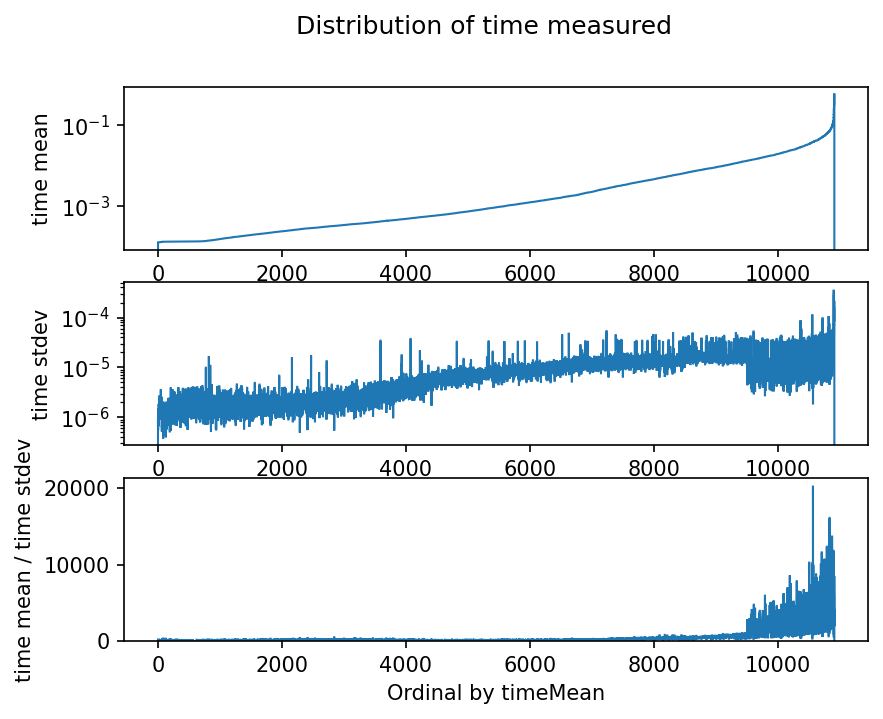

In [33]:
plt.rcParams['figure.dpi'] = 150
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle(f"Distribution of time measured")

ax1.stairs(timeMean)

# ax1.set_xlabel('Ordinal by timeMean')
ax1.set_ylabel('time mean')
ax1.set_yscale('log')

# ax2.bar([i for i in range(0, len(timeStdev))], timeStdev)
ax2.stairs(timeStdev)

ax2.set_ylabel('time stdev')
ax2.set_yscale('log')

meanByStd = timeMean / timeStdev
ax3.stairs(meanByStd)

ax3.set_xlabel('Ordinal by timeMean')
ax3.set_ylabel('time mean / time stdev')
# ax3.set_yscale('log')

plt.show()

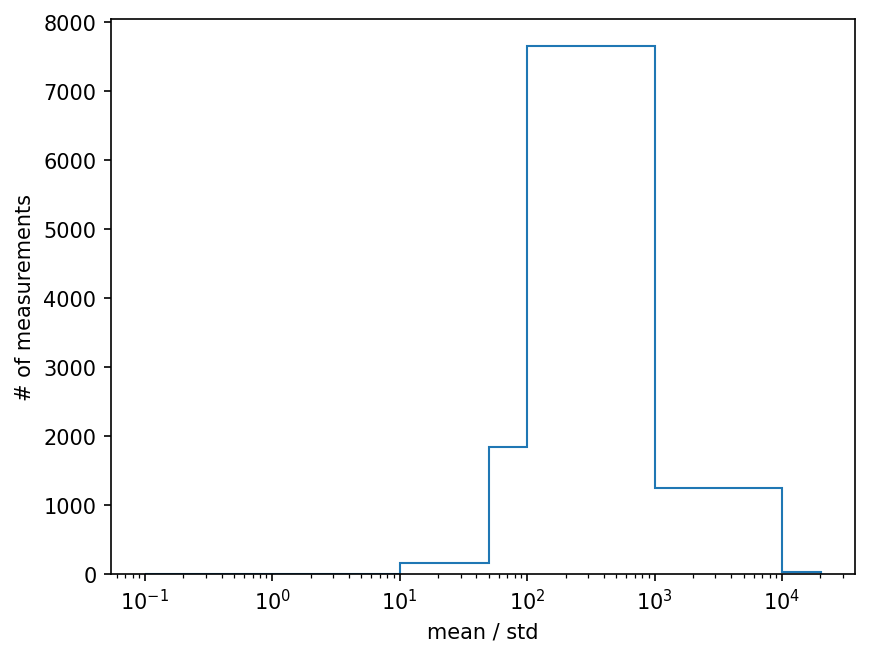

In [34]:
meanByStdSorted = np.sort(meanByStd)

separationPoint = [1e-1, 1e0, 1e1, 5e1, 1e2, 1e3, 1e4, np.max(meanByStdSorted)]
hist, binEdges = np.histogram(meanByStdSorted, bins=separationPoint)

fig, ax = plt.subplots()
ax.stairs(hist, binEdges)
ax.set_xscale('log')
ax.set_xlabel('mean / std')
ax.set_ylabel('# of measurements')
plt.show()

Statistics by slot used in metrics.

分为如下几组：
- `time >= 1e-1 sec` (也就是 `fps <= 10`)
- `1e-2 <= time < 1e-1` (也就是 `10 <= fps <= 100`)
- `1e-3 <= time < 1e-2` (也就是 `100 <= fps <= 1000`)
- `1e-4 <= time < 1e-3` (也就是 `1000 <= fps <= 10000`)
- `time < 1e-4` (也就是 `10000 < fps`)

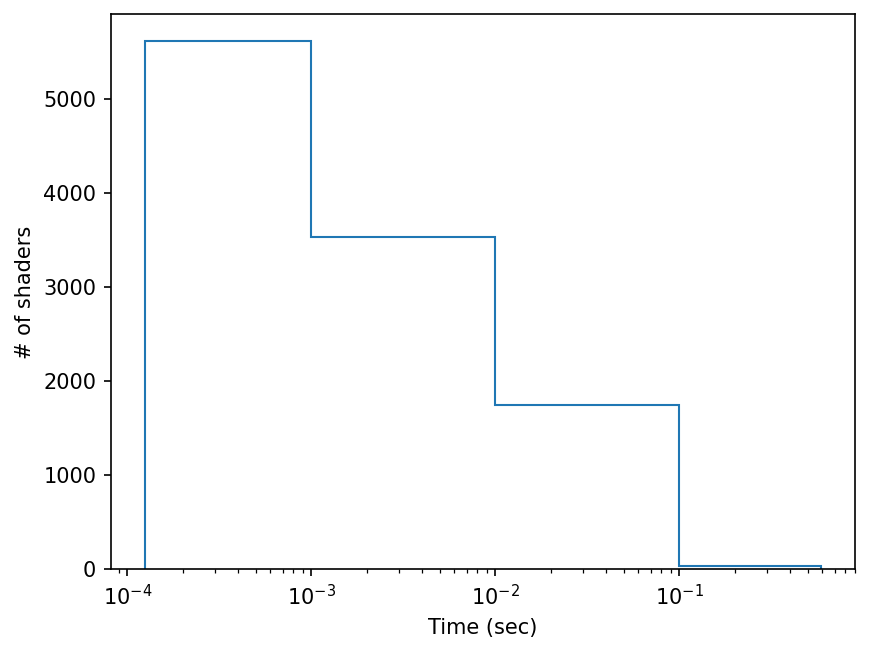

In [35]:
separationPoint = [np.min(timeMean), 1e-3, 1e-2, 1e-1, np.max(timeMean)]
hist, binEdges = np.histogram(timeMean, bins=separationPoint)

fig, ax = plt.subplots()
ax.stairs(hist, binEdges)
ax.set_xscale('log')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('# of shaders')
plt.show()

#### Normalized time comparison

- Mean-Stdev Normalizer
- LogPlusNormalizer

Normalizer name 'Normalizer', mean=-4.999512790323014e-16, stdev=0.9999541904303569
First 10 values: [-0.36967905 -0.36967792 -0.36967545 -0.36966801 -0.36966386 -0.36965977
 -0.36965722 -0.36965506 -0.36964953 -0.36964609];
Last 10 values: [13.39897562 14.07218275 14.19250164 15.47243561 16.65205717 19.6417008
 19.95912656 21.50282558 27.31309976 36.6216006 ]


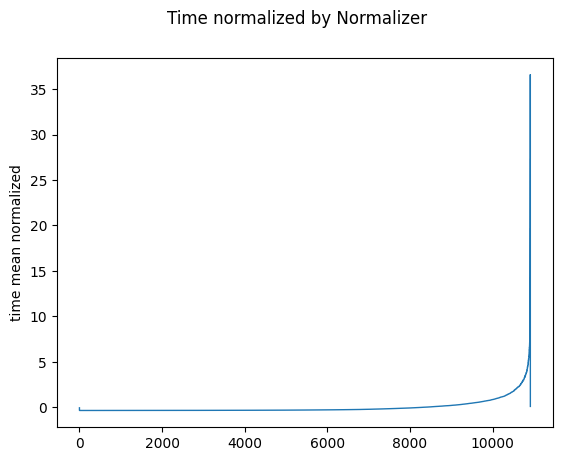

NOTE: No need to build from samples for LogPlusNormalizer
Normalizer name 'LogPlusNormalizer', mean=0.005900158412156994, stdev=0.014684429221245774
First 10 values: [0.00012439 0.00012441 0.00012445 0.00012457 0.00012464 0.0001247
 0.00012474 0.00012478 0.00012486 0.00012492];
Last 10 values: [0.19896316 0.20774102 0.20930176 0.2257556  0.24068384 0.27754916
 0.28138471 0.29983075 0.36635978 0.46449905]


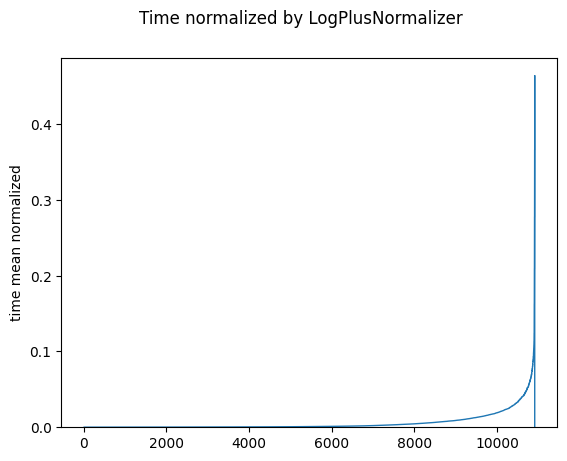

NOTE: No need to build from samples for LogNormalizer
Normalizer name 'LogNormalizer', mean=-6.644371883447716, stdev=1.7311504075891015
First 10 values: [-8.99200835 -8.99186322 -8.99154624 -8.99059143 -8.99005866 -8.98953508
 -8.9892077  -8.98893163 -8.98822398 -8.98778363];
Last 10 values: [-1.51350514 -1.46579503 -1.45750274 -1.37330184 -1.30151663 -1.13977495
 -1.12404325 -1.05087879 -0.81537331 -0.52557238]


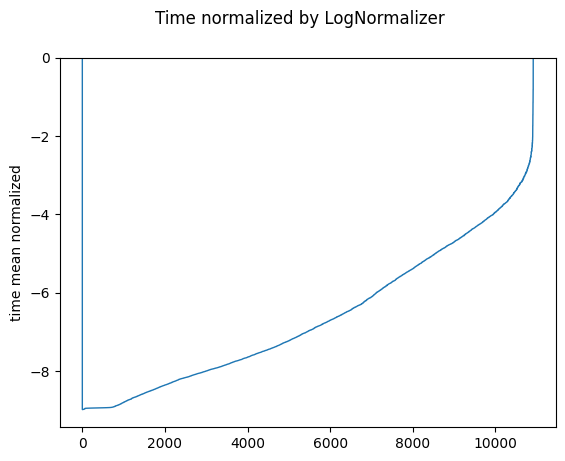

In [36]:
from misc.normalization import Normalizer, LogPlusNormalizer, LogNormalizer

def sampleIterator():
    numSamples = len(timeMean)
    for i in range(0, numSamples):
        yield timeMean[i]

# Mean-stdev normalizer
for normalizerCls in (Normalizer, LogPlusNormalizer, LogNormalizer):
    if hasattr(normalizerCls, 'buildFromSamples'):
        normalizer = normalizerCls.buildFromSamples(sampleIterator())
    else:
        print(f"NOTE: No need to build from samples for {normalizerCls.__name__}")
        normalizer = normalizerCls()
    normalizedMean = normalizer.normalize(timeMean)
    print(f"Normalizer name '{normalizerCls.__name__}', mean={np.mean(normalizedMean)}, stdev={np.std(normalizedMean)}")

    print(f"First 10 values: {normalizedMean[:10]};\nLast 10 values: {normalizedMean[-10:]}")

    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    fig.suptitle(f"Time normalized by {normalizerCls.__name__}")

    ax.stairs(normalizedMean)

    # ax1.set_xlabel('Ordinal by timeMean')
    ax.set_ylabel('time mean normalized')
    # ax.set_yscale('log')
    plt.show()


> Stair graph's first segment comes from (0, 0), so the graph itself is ok.

In [37]:
print(f"original time statistics: mean={np.mean(timeMean)} std={np.std(timeMean)}") 

original time statistics: mean=0.0060315895985602625 std=0.01597850618480406


### Distribution of basic block trace count

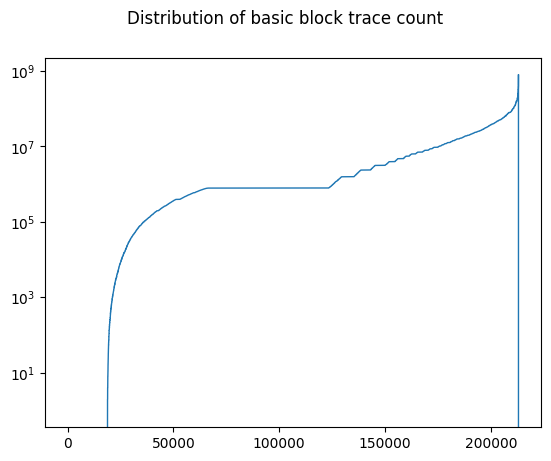

In [38]:
bbTraceCounts = []

for shaderId, expr in shader_to_experiment.items():
  bbTraceCounters = json.loads(expr.trace.bb_trace_counters)
  bbTraceCounts += bbTraceCounters

bbTraceCounts = np.array(bbTraceCounts, dtype=np.uint64)
bbTraceCounts = np.sort(bbTraceCounts)

fig, ax = plt.subplots()
fig.suptitle('Distribution of basic block trace count')

ax.stairs(bbTraceCounts)
ax.set_yscale('log')

plt.show()

In [39]:
print(f"Maximum value: {np.max(bbTraceCounts):.10e}")

Maximum value: 8.0530636800e+08


#### Test for normalizer impact on trace count

Normalizer name 'Normalizer', mean=1.150340594287477e-15, stdev=0.9999976534056696
First 10 values: [-0.36291915 -0.36291915 -0.36291915 -0.36291915 -0.36291915 -0.36291915
 -0.36291915 -0.36291915 -0.36291915 -0.36291915];
Last 10 values: [24.11543575 25.65766933 25.93157026 25.93157026 26.74525724 27.02717399
 28.73905481 29.97942726 30.96449988 34.69640007]


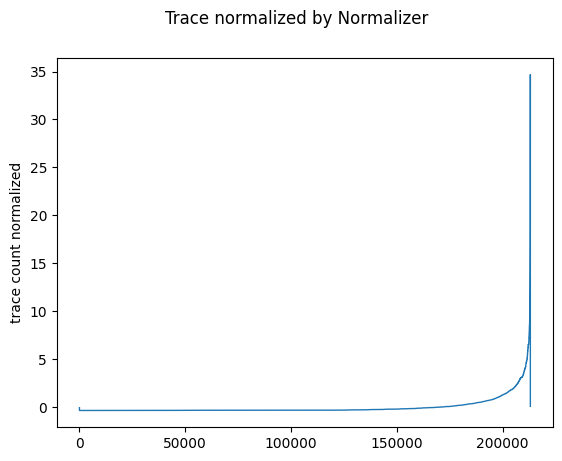

NOTE: No need to build from samples for LogPlusNormalizer
Normalizer name 'LogPlusNormalizer', mean=12.892142882897248, stdev=4.569850065031053
First 10 values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.];
Last 10 values: [20.14748114 20.20857997 20.21905127 20.21905127 20.24952728 20.25987327
 20.32049789 20.36223619 20.39418561 20.50673335]


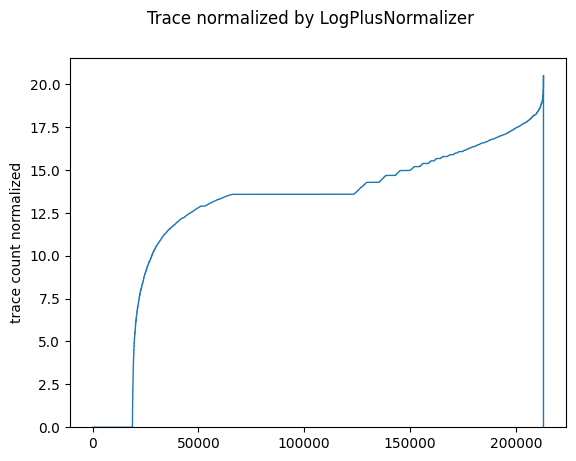

NOTE: No need to build from samples for LogNormalizer
Normalizer name 'LogNormalizer', mean=-inf, stdev=nan
First 10 values: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf];
Last 10 values: [20.14748114 20.20857997 20.21905127 20.21905127 20.24952728 20.25987327
 20.32049789 20.36223619 20.3941856  20.50673334]


c:\Projects\NGPP\vkPredict\notebooks\..\misc\normalization.py:95: RuntimeWarning: divide by zero encountered in log
  return np.log(sample)
c:\Projects\NGPP\venv\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


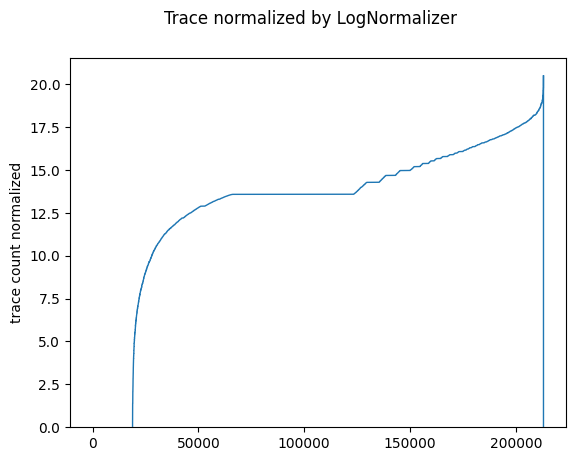

In [40]:
def sampleIterator():
    numSamples = len(bbTraceCounts)
    for i in range(0, numSamples):
        yield bbTraceCounts[i]

# Mean-stdev normalizer
for normalizerCls in (Normalizer, LogPlusNormalizer, LogNormalizer):
    if hasattr(normalizerCls, 'buildFromSamples'):
        normalizer = normalizerCls.buildFromSamples(sampleIterator())
    else:
        print(f"NOTE: No need to build from samples for {normalizerCls.__name__}")
        normalizer = normalizerCls()
    normalizedTraceCount = normalizer.normalize(bbTraceCounts)
    print(f"Normalizer name '{normalizerCls.__name__}', mean={np.mean(normalizedTraceCount)}, stdev={np.std(normalizedTraceCount)}")

    print(f"First 10 values: {normalizedTraceCount[:10]};\nLast 10 values: {normalizedTraceCount[-10:]}")

    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    fig.suptitle(f"Trace normalized by {normalizerCls.__name__}")

    ax.stairs(normalizedTraceCount)

    # ax1.set_xlabel('Ordinal by timeMean')
    ax.set_ylabel('trace count normalized')
    # ax.set_yscale('log')
    plt.show()

Test for occurance count on using binary encoding

In [41]:
def do_onehot_base2(trace_labels_raw: torch.Tensor, d_embed: int, shifted=False) -> 'torch.Tensor':
    bsz, seq_len = trace_labels_raw.size()
    trace_labels = trace_labels_raw.to(dtype=torch.int64, device=trace_labels_raw.device)
    ones = torch.ones((d_embed,), dtype=torch.int64, device=trace_labels.device)

    # (d_embed, )
    masks = torch.bitwise_left_shift(ones, torch.arange(d_embed, device=trace_labels.device))
    trace_embeds = (torch.bitwise_and(trace_labels.view(bsz, seq_len, 1), masks.view(1, 1, d_embed)) > 0).float()
    if shifted:
        trace_embeds -= 0.5

    return trace_embeds

trace_labels = torch.as_tensor(bbTraceCounts.astype(dtype=np.int64)).unsqueeze(0)
print(trace_labels.size())

trace_embeds = do_onehot_base2(trace_labels, 64).squeeze()
print(trace_embeds.size())

summed = torch.sum(trace_embeds, dim=0, dtype=torch.int64)
print(summed.size())
print(summed)

print(torch.sum((summed > 0).int()))
print(torch.nonzero(summed)[-1])

torch.Size([1, 213075])
torch.Size([213075, 64])
torch.Size([64])
tensor([ 32512,  36944,  40000,  41483,  41037,  41242,  41766,  42211,  43296,
         42883,  44105,  44422,  44666,  43825,  42757,  42996,  42834,  42410,
        107845, 109785,  47946,  45507,  34770,  26404,  17685,  10300,   4686,
          1218,    151,     10,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
tensor(30)
tensor([29])


所以，看起来可以测试测试 `` 选择 37，33，30 下的表现

### TODO: Test for type and ExtInst compaction